## Attention mechanisms to multi-feature time series sensor data for predicting equipment degradation
- Gemini 2.5 Flash

Applying attention mechanisms to multi-feature time series sensor data for predicting equipment degradation is a powerful approach. Attention allows the model to selectively focus on the most relevant features and time steps in the input sequence, which is crucial for identifying subtle patterns indicating degradation.

Here's a breakdown of the concepts, relevant Python packages, and a conceptual example.

**Key Concepts**
Multi-feature Time Series Data: Your sensor data will likely have multiple readings (e.g., temperature, pressure, vibration, current, etc.) taken over time. Each of these is a feature, and together they form a multivariate time series.

Equipment Degradation Prediction: This is often framed as:

Regression: Predicting the Remaining Useful Life (RUL) of the equipment (e.g., in cycles, hours). The "point where equipment degrades" could be defined as when RUL falls below a certain threshold.

Classification: Predicting if the equipment will degrade within a certain future time window (e.g., binary classification: "will degrade in next X hours" vs. "will not degrade").

Anomaly Detection: Identifying abnormal patterns that precede degradation, though this might not directly predict the degradation point but rather a deviation from normal operation.

**Attention Mechanism**: Instead of treating all past data points equally, attention mechanisms assign different weights to different parts of the input sequence. For equipment degradation, this means the model can learn to pay more attention to sensor readings that are highly indicative of wear or impending failure, even if they occurred earlier in the sequence.

**Self-Attention (Transformer-based)**: Each element in the input sequence attends to all other elements, capturing long-range dependencies within the sequence. This is very popular for time series.

**Encoder-Decoder with Attention**: An encoder processes the input sequence, and a decoder uses an attention mechanism to focus on relevant parts of the encoded sequence when making predictions.

**Temporal Attention**: Focuses on which time steps are most important.

**Feature Attention (Channel Attention)**: Focuses on which sensor features are most important.

**Conceptual Code Example** (Keras/TensorFlow)
This example focuses on a regression task to predict a degradation score or RUL, where higher scores indicate more degradation. The "point where equipment degrades" would then be when this predicted score crosses a pre-defined threshold.

**Assumptions for the Example**:
- You have historical sensor data for multiple pieces of equipment.
- For each piece of equipment, you have sensor readings over time (multi-feature).
- You have a target variable representing the "tool wear reading" or a derived degradation score for each time step.
- The data is structured as sequences.

**Explanation and Considerations for Your Goal**
**Data Preparation is Crucial**:
- **Sequence Length**: How many past time steps are relevant for predicting degradation? This seq_length needs to be carefully chosen.
- **Target Variable Definition**: The tool wear readings are your target. If they are directly numerical, great. If they are qualitative, you might need to map them to a numerical degradation score.
- **Sliding Window**: For continuous sensor data, you'll typically use a sliding window approach to create sequences for training and prediction. Each window becomes an input to your model, and the target is the degradation at the end of that window (or a future point).
- **Data Alignment**: Ensure your sensor features and tool wear readings are perfectly aligned in time.
- **Scaling**: Normalize or standardize your sensor data and target values (if continuous) to improve model performance. MinMaxScaler is a good starting point.

**Model Architecture**:

**LSTM/GRU Encoder**: Recurrent layers (LSTM or GRU) are excellent for capturing temporal dependencies in time series data. Setting return_sequences=True in the encoder is essential because the attention mechanism needs to "see" all the hidden states from the input sequence.

**Attention Layer**: Keras's Attention layer (or AdditiveAttention, MultiHeadAttention for more complex setups) is a good starting point. It takes a query, key, and value to compute attention weights and a context vector. For self-attention, typically query, key, and value are derived from the same source (e.g., encoder_outputs).

**Output Layer**: The final Dense(1, activation='linear') layer is for regression (predicting a continuous degradation score).

**Predicting the Degradation Point**:

**Thresholding**: Once your model predicts a continuous degradation score, you'll need to define a threshold. When the predicted score crosses this threshold, you consider it the "degradation point." This threshold should be determined based on your historical knowledge of tool wear readings and operational limits.

**Sliding Window Prediction**: For a new, live sensor stream, you would continuously feed fixed-length windows of data into your trained model. When the model's output for a window exceeds your predefined degradation threshold, you can flag that time as the degradation onset.

**Interpreting Attention Weights**: This is the big advantage of using attention for your problem.

By visualizing the attention weights, you can see which specific sensor features and which time points the model considered most important when making a degradation prediction.

For example, if vibration data significantly increases attention weights just before a known degradation event, it confirms the model learned this correlation. This provides valuable insights for engineers and domain experts.

Extracting attention weights often requires modifying the model to output them, or building a custom attention layer that exposes these weights.

**Handling Multi-Feature Attention**: The Attention layer in Keras, as used above, primarily applies temporal attention across the lstm_units dimension. For explicitly attending to features within each timestep (channel attention) or a combination of both, you might need more complex Transformer-like architectures (e.g., using MultiHeadAttention and careful reshaping) or custom attention mechanisms that operate across the feature dimension.

This example provides a solid foundation. Remember to adapt the data generation, preprocessing, model architecture, and particularly the interpretation steps to your specific dataset and the nuances of your equipment degradation problem.

## Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

### Set-up

In [45]:
# Set a random seed for reproducibility
# np.random.seed(42)
# tf.random.set_seed(42)
EPISODES = 100

## Generate data

X_raw shape: (200, 100, 5)
y_raw shape: (200, 100)


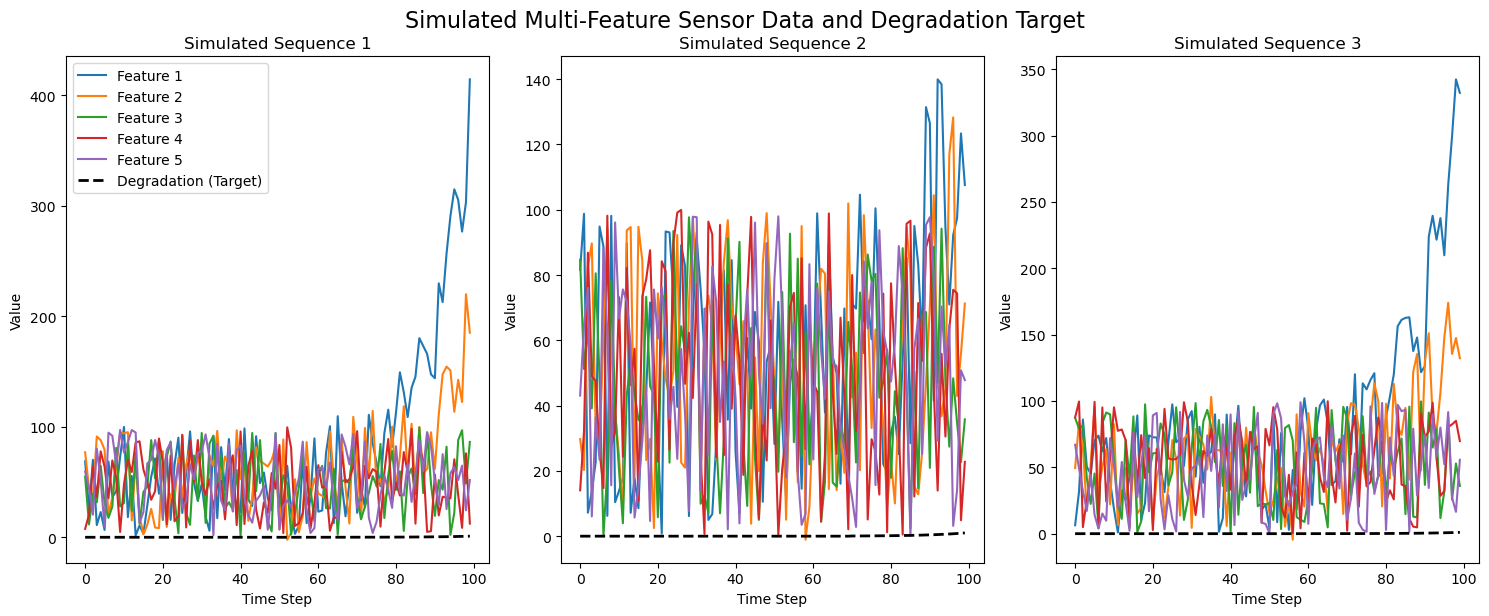

In [46]:
# --- 1. Data Generation (Conceptual - Replace with your actual sensor data) ---
def generate_degradation_data(num_sequences=200, seq_length=100, num_features=5):
    all_sequences = []
    all_targets = []

    for _ in range(num_sequences):
        # Simulate sensor features (e.g., temperature, vibration, current, etc.)
        features = np.random.rand(seq_length, num_features) * 100
        
        # Simulate degradation: starts low, increases, then accelerates
        degradation_signal = np.zeros(seq_length)
        degradation_start_point = np.random.randint(seq_length // 2, seq_length - 10)
        
        for i in range(seq_length):
            if i >= degradation_start_point:
                # Exponential degradation after a certain point
                degradation_signal[i] = 10 * np.exp((i - degradation_start_point) * 0.1) + np.random.randn() * 0.5
            else:
                degradation_signal[i] = np.random.randn() * 0.1 # Some noise before degradation
        
        # Add some sensor features that correlate with degradation
        features[:, 0] += degradation_signal * 0.5 # Feature 0 increases with degradation
        features[:, 1] += np.sin(np.arange(seq_length) / 5) * 5 + degradation_signal * 0.2 # Feature 1 has pattern + degradation
        
        # Normalize degradation_signal to be between 0 and 1 (or some defined scale)
        max_deg = np.max(degradation_signal)
        if max_deg > 0:
            degradation_signal = degradation_signal / max_deg
        
        all_sequences.append(features)
        all_targets.append(degradation_signal) # Target is the degradation level at each step

    return np.array(all_sequences), np.array(all_targets)

X_raw, y_raw = generate_degradation_data(num_sequences=200, seq_length=100, num_features=5)
print(f"X_raw shape: {X_raw.shape}") # (num_sequences, seq_length, num_features)
print(f"y_raw shape: {y_raw.shape}") # (num_sequences, seq_length)

# --- Visualize Simulated X and Y for a few sequences ---
plt.figure(figsize=(15, 6))
for i in range(3): # Plot 3 example sequences
    plt.subplot(1, 3, i + 1)
    for j in range(X_raw.shape[2]):
        plt.plot(X_raw[i, :, j], label=f'Feature {j+1}')
    plt.plot(y_raw[i, :], label='Degradation (Target)', color='black', linestyle='--', linewidth=2)
    plt.title(f'Simulated Sequence {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.suptitle('Simulated Multi-Feature Sensor Data and Degradation Target', y=1.02, fontsize=16)
plt.show()

In [47]:
# --- 2. Preprocessing ---
num_sequences, seq_length, num_features = X_raw.shape
X_flat = X_raw.reshape(-1, num_features)

scaler_X = MinMaxScaler()
X_scaled_flat = scaler_X.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(num_sequences, seq_length, num_features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).reshape(num_sequences, seq_length)

# We are predicting the degradation at the final timestep of each sequence.
X = X_scaled
y = y_scaled[:, -1] # Predicting the degradation at the final timestep

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data X shape: {X_train.shape}")
print(f"Training data y shape: {y_train.shape}")
print(f"Test data X shape: {X_test.shape}")
print(f"Test data y shape: {y_test.shape}")



Training data X shape: (160, 100, 5)
Training data y shape: (160,)
Test data X shape: (40, 100, 5)
Test data y shape: (40,)


In [48]:
# --- 3. Custom Attention Layer to expose weights ---
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DotProductAttention, self).build(input_shape)

    def call(self, inputs):
        query = inputs[0] 
        key = inputs[1]   
        value = inputs[2] 

        scores = tf.matmul(query, key, transpose_b=True)

        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = scores / tf.math.sqrt(dk)

        attention_weights = tf.nn.softmax(scaled_scores, axis=-1) 

        context_vector = tf.matmul(attention_weights, value)
        
        return context_vector, attention_weights 

    def get_config(self):
        config = super(DotProductAttention, self).get_config()
        return config


In [49]:
# --- 4. Build the Attention Model with custom layer ---
def build_attention_model(input_shape, lstm_units=64, dense_units=32):
    inputs = Input(shape=input_shape) # (seq_length, num_features)

    encoder_outputs, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True)(inputs)

    # Naming the attention layer to make its output name predictable
    attention_output, attention_weights = DotProductAttention(name='attention_weights_output')([encoder_outputs, encoder_outputs, encoder_outputs])

    attended_representation = tf.reduce_mean(attention_output, axis=1) # (batch_size, lstm_units)

    x = Dense(dense_units, activation='relu')(attended_representation)
    # Naming the final dense layer for prediction
    output = Dense(1, activation='linear', name='degradation_prediction')(x) 

    model = Model(inputs=inputs, outputs=[output, attention_weights])
    return model

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2]) # (seq_length, num_features)
model = build_attention_model(input_shape)

# --- Print output names to ensure correct mapping ---
print(f"\nModel output names: {model.output_names}")
prediction_output_name = model.output_names[0] # Should be 'degradation_prediction'
attention_output_name = model.output_names[1] # Should be 'attention_weights_output'


# Compile the model using the actual output names
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss={prediction_output_name: 'mse', attention_output_name: None}, 
              metrics={prediction_output_name: ['mae']},
              loss_weights={prediction_output_name: 1.0, attention_output_name: 0.0}
             )
model.summary()


Model output names: ['degradation_prediction', 'attention_weights_output']
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 5)]     0           []                               
                                                                                                  
 lstm_7 (LSTM)                  [(None, 100, 64),    17920       ['input_8[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 attention_weights_output (DotP  ((None, 100, 64),   0           ['lstm_7[0][0]',                 
 roductAttention

In [50]:
# --- 5. Train the model ---
early_stopping = EarlyStopping(monitor=f'val_{prediction_output_name}_loss', patience=10, restore_best_weights=True)

# When fitting, y_train needs to be a dictionary of targets corresponding to output names
history = model.fit(
    X_train, {prediction_output_name: y_train, attention_output_name: np.zeros((len(X_train), seq_length, seq_length))}, # Dummy target for attention_weights
    epochs=EPISODES,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
5/5 [==============================] - 3s 138ms/step - loss: 1.0148 - degradation_prediction_loss: 1.0148 - degradation_prediction_mae: 1.0042 - val_loss: 0.7200 - val_degradation_prediction_loss: 0.7200 - val_degradation_prediction_mae: 0.8485
Epoch 2/100
5/5 [==============================] - 0s 41ms/step - loss: 0.6016 - degradation_prediction_loss: 0.6016 - degradation_prediction_mae: 0.7735 - val_loss: 0.3754 - val_degradation_prediction_loss: 0.3754 - val_degradation_prediction_mae: 0.6126
Epoch 3/100
5/5 [==============================] - 0s 39ms/step - loss: 0.2313 - degradation_prediction_loss: 0.2313 - degradation_prediction_mae: 0.4656 - val_loss: 0.0090 - val_degradation_prediction_loss: 0.0090 - val_degradation_prediction_mae: 0.0931
Epoch 4/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0442 - degradation_prediction_loss: 0.0442 - degradation_prediction_mae: 0.1860 - val_loss: 0.0747 - val_degradation_prediction_loss: 0.0747 - val_degradatio

In [51]:
# --- 6. Evaluate the model ---
# When evaluating, you also need to provide dummy target for the attention weights output
results = model.evaluate(X_test, {prediction_output_name: y_test, attention_output_name: np.zeros((len(X_test), seq_length, seq_length))}, verbose=0)

# Retrieve loss and MAE using model.metrics_names
# model.metrics_names will contain entries like 'loss', 'degradation_prediction_loss',
# 'attention_weights_output_loss', 'degradation_prediction_mae'
loss_name = f'{prediction_output_name}_loss'
mae_name = f'{prediction_output_name}_mae'

# Find the indices of the desired metrics in the results list
loss_idx = model.metrics_names.index(loss_name)
mae_idx = model.metrics_names.index(mae_name)

loss = results[loss_idx]
mae = results[mae_idx]

print(f"\nTest Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")


Test Loss (MSE): 0.0002
Test MAE: 0.0099


2/2 [==============================] - 0s 16ms/step

Sample Predictions vs. Actual (Original Scale):
Predicted: 1.00, Actual: 1.00
Predicted: 0.99, Actual: 1.00
Predicted: 1.01, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 1.03, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 1.01, Actual: 1.00


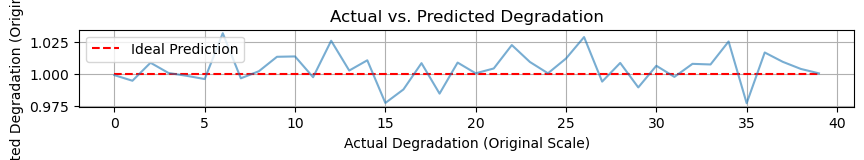

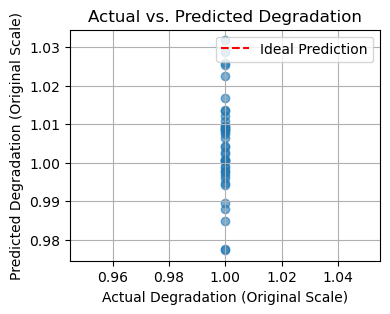

In [52]:
# --- 7. Make Predictions and Compare Actual vs. Predicted ---
predictions_outputs = model.predict(X_test)
predictions_scaled = predictions_outputs[0] # The first output is our degradation prediction
attention_weights_test = predictions_outputs[1] # The second output is the attention weights

predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

print("\nSample Predictions vs. Actual (Original Scale):")
for i in range(10):
    print(f"Predicted: {predictions[i][0]:.2f}, Actual: {y_test_original[i][0]:.2f}")

# Visualization: Actual vs. Predicted Degradation
plt.figure(figsize=(10, 1))
plt.plot(y_test_original, 'r--')
plt.plot(predictions, alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--', label='Ideal Prediction')
plt.title('Actual vs. Predicted Degradation')
plt.xlabel('Actual Degradation (Original Scale)')
plt.ylabel('Predicted Degradation (Original Scale)')
plt.grid(True)
plt.legend()
plt.show()

# Visualization: Actual vs. Predicted Degradation
plt.figure(figsize=(4, 3))
plt.scatter(y_test_original, predictions, alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--', label='Ideal Prediction')
plt.title('Actual vs. Predicted Degradation')
plt.xlabel('Actual Degradation (Original Scale)')
plt.ylabel('Predicted Degradation (Original Scale)')
plt.grid(True)
plt.legend()
plt.show()


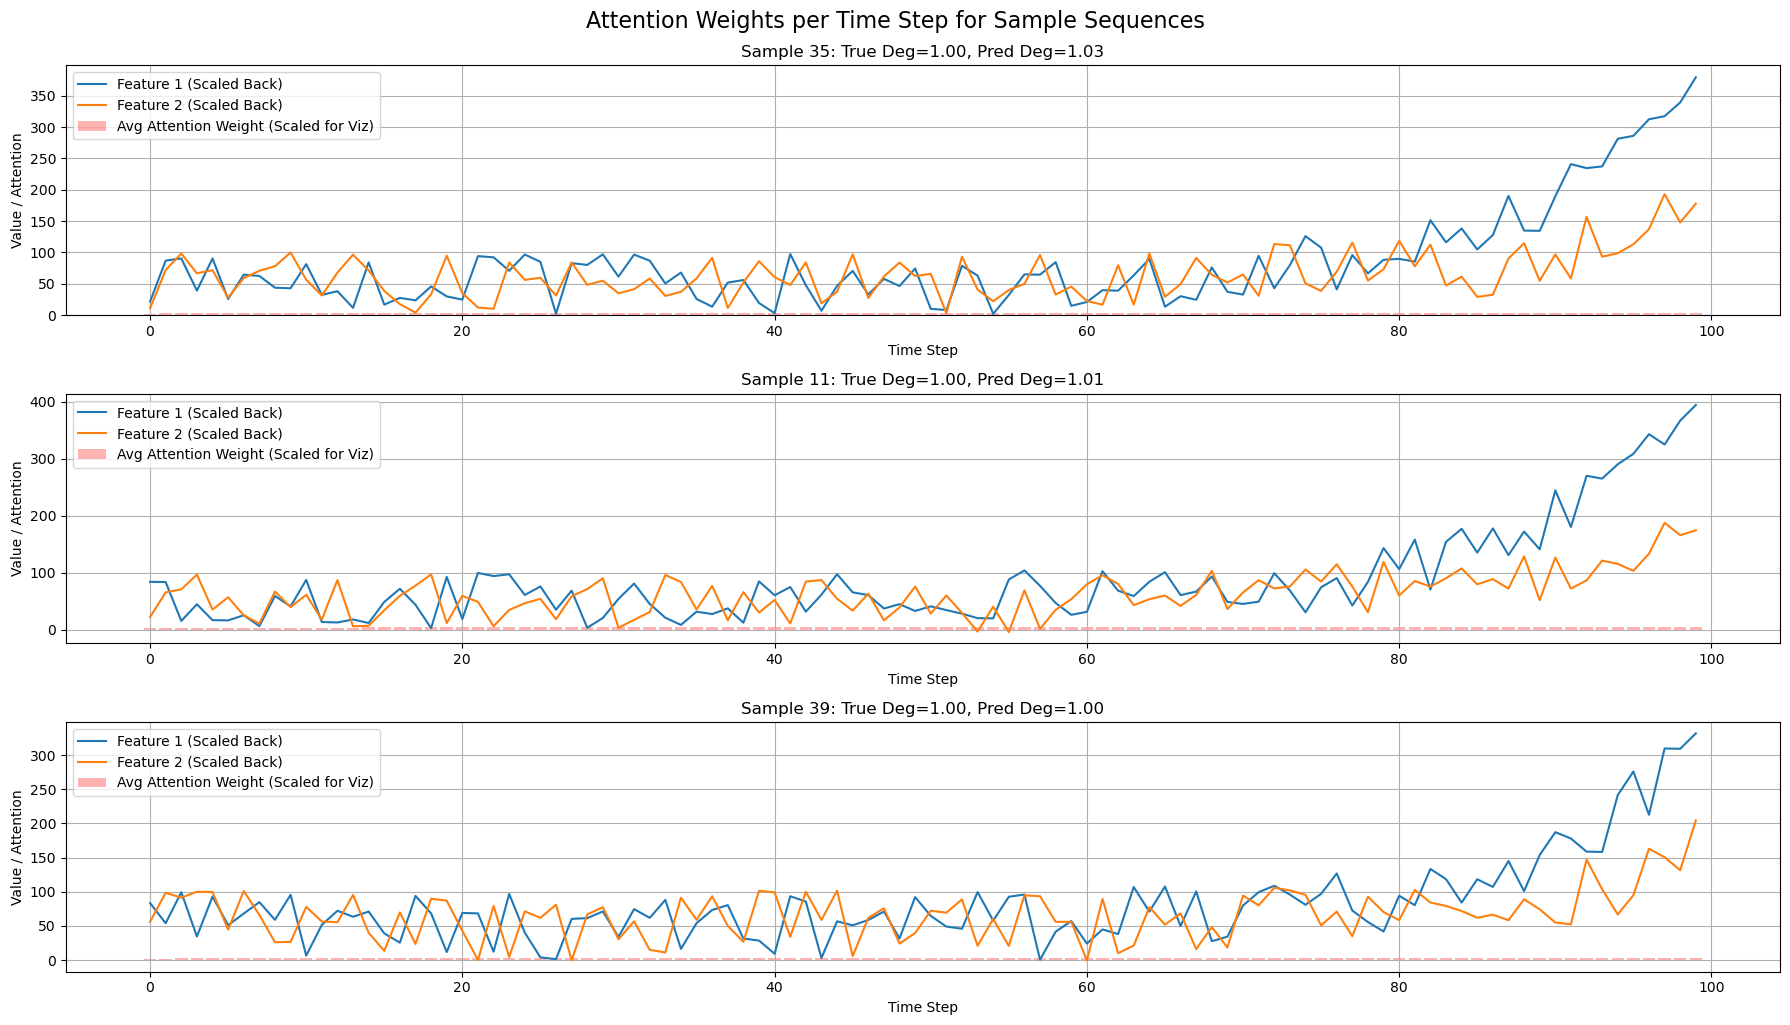

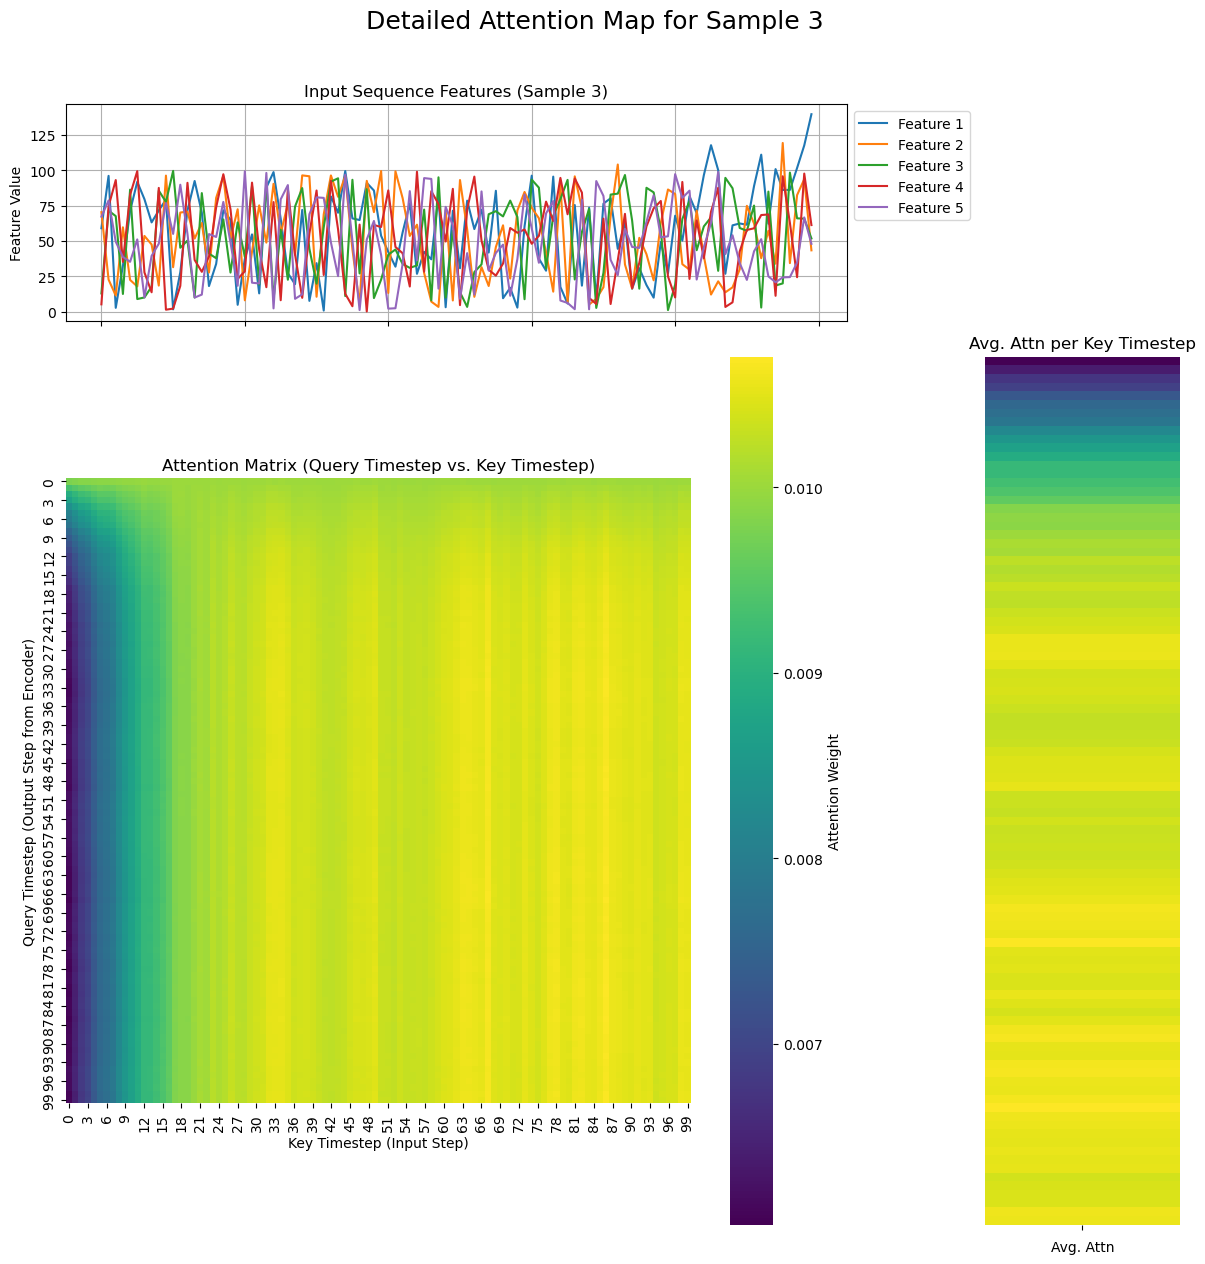


--- Interpreting Attention Weights ---
The heatmaps show how much each output (query) time step from the encoder (y-axis) attended to each input (key) time step (x-axis).
For a regression task that outputs a single value based on the whole sequence, we often look at an aggregated view of attention.
The 'Avg. Attn per Key Timestep' bar plot (or right-side heatmap) indicates which input time steps were, on average, most influential.
Higher values in this averaged attention indicate that those specific time steps in the input sequence
(e.g., later stages where degradation accelerates) were more important for the model's prediction.


In [60]:
# --- 8. Visualize Attention Weights ---
# Pick a few test samples to visualize attention
num_samples_to_visualize = 3
sample_indices = np.random.choice(len(X_test), num_samples_to_visualize, replace=False)

plt.figure(figsize=(18, 10))
for i, sample_idx in enumerate(sample_indices):
    sample_input = X_test[sample_idx]
    sample_true_y = y_test_original[sample_idx][0]
    sample_predicted_y = predictions[sample_idx][0]
    
    avg_attention_weights = np.mean(attention_weights_test[sample_idx], axis=0) # Average over query dimension
    
    # Plotting
    plt.subplot(num_samples_to_visualize, 1, i + 1)
    
    # Plot one of the original features for context
    plt.plot(scaler_X.inverse_transform(X_test[sample_idx])[:, 0], label='Feature 1 (Scaled Back)')
    plt.plot(scaler_X.inverse_transform(X_test[sample_idx])[:, 1], label='Feature 2 (Scaled Back)')
    
    # Plot the attention weights
    plt.bar(range(seq_length), avg_attention_weights * np.max(scaler_X.inverse_transform(X_test[sample_idx])[:, 0]), 
            alpha=0.3, color='red', label='Avg Attention Weight (Scaled for Viz)')
    
    plt.title(f'Sample {sample_idx+1}: True Deg={sample_true_y:.2f}, Pred Deg={sample_predicted_y:.2f}')
    plt.xlabel('Time Step')
    plt.ylabel('Value / Attention')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Attention Weights per Time Step for Sample Sequences', y=1.02, fontsize=16)
plt.show()

# More specific interpretation of attention weights: Heatmap
# Let's pick one specific sample for a detailed heatmap of attention weights (seq_length x seq_length)
sample_idx_for_heatmap = 3 # You can choose any index from your test set

# Get the raw (unscaled) input sequence for context
sample_input_raw = scaler_X.inverse_transform(X_test[sample_idx_for_heatmap])
sample_attention_matrix = attention_weights_test[sample_idx_for_heatmap]

plt.figure(figsize=(12, 12))
gs = plt.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])

# Plot Input Features
ax0 = plt.subplot(gs[0, 0])
for j in range(num_features):
    ax0.plot(sample_input_raw[:, j], label=f'Feature {j+1}')
ax0.set_title(f'Input Sequence Features (Sample {sample_idx_for_heatmap})')
ax0.set_ylabel('Feature Value')
ax0.set_xticklabels([]) # Hide x-axis labels for top plot
ax0.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax0.grid(True)

# Plot Attention Heatmap
ax1 = plt.subplot(gs[1, 0])
sns.heatmap(sample_attention_matrix, cmap='viridis', ax=ax1, cbar_kws={'label': 'Attention Weight'})
ax1.set_title('Attention Matrix (Query Timestep vs. Key Timestep)')
ax1.set_xlabel('Key Timestep (Input Step)')
ax1.set_ylabel('Query Timestep (Output Step from Encoder)')
ax1.set_aspect('equal', adjustable='box')


# Plot the overall attention contribution (averaged across queries)
ax2 = plt.subplot(gs[1, 1])
avg_attention_heatmap = np.mean(sample_attention_matrix, axis=0).reshape(-1, 1) # Average over query, reshape for heatmap
sns.heatmap(avg_attention_heatmap, cmap='viridis', ax=ax2, cbar=False, yticklabels=False)
ax2.set_title('Avg. Attn per Key Timestep')
ax2.set_ylabel('')
ax2.set_xticklabels([])
ax2.set_xlabel('Avg. Attn')


plt.tight_layout()
plt.suptitle(f'Detailed Attention Map for Sample {sample_idx_for_heatmap}', y=1.05, fontsize=18)
plt.show()

print("\n--- Interpreting Attention Weights ---")
print("The heatmaps show how much each output (query) time step from the encoder (y-axis) attended to each input (key) time step (x-axis).")
print("For a regression task that outputs a single value based on the whole sequence, we often look at an aggregated view of attention.")
print("The 'Avg. Attn per Key Timestep' bar plot (or right-side heatmap) indicates which input time steps were, on average, most influential.")
print("Higher values in this averaged attention indicate that those specific time steps in the input sequence")
print("(e.g., later stages where degradation accelerates) were more important for the model's prediction.")